<a href="https://colab.research.google.com/github/xeromark/TareasIA/blob/main/Tareas%203/TareaIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tarea 3 de IA de Omar Marca y Luis Reyes. Github: https://github.com/xeromark/TareasIA



# Pregunta 1

## Reproduzca el tutorial implementando la arquitectura. Comente paso a paso lo que se hace en sus propias palabras.

Las neuronas KAN utilizan funciones de borde no lineales para transformar las entradas con el objetivo de que se pueda procesar la información con menos recursos computacionales y realizar cálculos más complejos.



Por otra parte, en MLP las entradas se transforman mediante funciones de activación lineales o no lineales para introducir no linealidades en el modelo, es decir, que el modelo sea capaz de representar relaciones complejas entre las variables de entrada y salida que no pueden ser descritas por una simple relación lineal.




### Neurona

Para poder utilizar MLP y KAN, se establecen métodos en python para proporcionar una estructura versátil que pueda acomodar tanto las Redes de Kolmogorov-Arnold (KAN) como los Perceptrones Multicapa (MLP). Es por ello que se tienen los siguientes métodos del funcionamiento de una neurona:

In [ ]:
import numpy as np

class Neuron:

    def __init__(self, n_in, n_weights_per_edge, weights_range=None):
        self.n_in = n_in  # n. inputs
        self.n_weights_per_edge = n_weights_per_edge
        weights_range = [-1, 1] if weights_range is None else weights_range
        self.weights = np.random.uniform(weights_range[0], weights_range[-1], size=(self.n_in, self.n_weights_per_edge))
        self.bias = 0
        self.xin = None  # input variable
        self.xmid = None  # edge variables
        self.xout = None  # output variable
        self.dxout_dxmid = None  # derivative d xout / d xmid: (n_in, )
        self.dxout_dbias = None  # derivative d xout / d bias
        self.dxmid_dw = None  # derivative d xmid / d w: (n_in, n_par_per_edge)
        self.dxmid_dxin = None  # derivative d xmid / d xin
        self.dxout_dxin = None  # (composite) derivative d xout / d xin
        self.dxout_dw = None  # (composite) derivative d xout / d w
        self.dloss_dw = np.zeros((self.n_in, self.n_weights_per_edge))  # (composite) derivative d loss / d w
        self.dloss_dbias = 0  # (composite) derivative d loss / d bias

    def __call__(self, xin):
        # forward pass: compute neuron's output
        self.xin = np.array(xin)
        self.get_xmid()
        self.get_xout()

        # compute internal derivatives
        self.get_dxout_dxmid()
        self.get_dxout_dbias()
        self.get_dxmid_dw()
        self.get_dxmid_dxin()

        assert self.dxout_dxmid.shape == (self.n_in, )
        assert self.dxmid_dxin.shape == (self.n_in, )
        assert self.dxmid_dw.shape == (self.n_in, self.n_weights_per_edge)

        # compute external derivatives
        self.get_dxout_dxin()
        self.get_dxout_dw()

        return self.xout

    def get_xmid(self):
        # compute self.xmid
        pass

    def get_xout(self):
        # compute self.xout
        pass

    def get_dxout_dxmid(self):
        # compute self.dxout_dxmid
        pass

    def get_dxout_dbias(self):
        # compute self.dxout_dbias
        pass  #self.dxout_dbias = 0  # by default

    def get_dxmid_dw(self):
        # compute self.dxmid_dw
        pass

    def get_dxmid_dxin(self):
        # compute self.dxmid_dxin
        pass

    def get_dxout_dxin(self):
        self.dxout_dxin = self.dxout_dxmid * self.dxmid_dxin

    def get_dxout_dw(self):
        self.dxout_dw = np.diag(self.dxout_dxmid) @ self.dxmid_dw

    def update_dloss_dw_dbias(self, dloss_dxout):
        self.dloss_dw += self.dxout_dw * dloss_dxout
        self.dloss_dbias += self.dxout_dbias * dloss_dxout

    def gradient_descent(self, eps):
        self.weights -= eps * self.dloss_dw
        self.bias -= eps * self.dloss_dbias

### Función de activación

Para poder facilitar el uso de las funciones de Activación, se definen los siguientes métodos:

In [ ]:
import math

def relu(x, get_derivative=False):
    return x * (x > 0) if not get_derivative else 1.0 * (x >= 0)

def tanh_act(x, get_derivative=False):
    if not get_derivative:
        return math.tanh(x)
    return 1 - math.tanh(x) ** 2

def sigmoid_act(x, get_derivative=False):
    if not get_derivative:
        return 1 / (1 + math.exp(-x))
    return sigmoid_act(x) * (1 - sigmoid_act(x))

### MLP Métodos

Luego se define la clase NeuronNN que implementa los métodos de MLP. Esta clase se inicializa con el número de entradas **(n_in)**, un rango que es opcional para los pesos **(weights_range)** y una función de activación **(activation)**. Por defecto, la función de activación es **ReLU**.

In [ ]:
class NeuronNN(Neuron):

    def __init__(self, n_in, weights_range=None, activation=relu):
        super().__init__(n_in, n_weights_per_edge=1, weights_range=weights_range)
        self.activation = activation
        self.activation_input = None

    def get_xmid(self):
        self.xmid = self.weights[:, 0] * self.xin

    def get_xout(self):
        self.activation_input = sum(self.xmid.flatten()) + self.bias
        self.xout = self.activation(self.activation_input, get_derivative=False)

    def get_dxout_dxmid(self):
        self.dxout_dxmid = self.activation(self.activation_input, get_derivative=True) * np.ones(self.n_in)

    def get_dxout_dbias(self):
        self.dxout_dbias = self.activation(self.activation_input, get_derivative=True)

    def get_dxmid_dw(self):
        self.dxmid_dw = np.reshape(self.xin, (-1, 1))

    def get_dxmid_dxin(self):
        self.dxmid_dxin = self.weights.flatten()

Luego, se define la función **get_bsplines()** para genera un conjunto de funciones borde no lineales (B-splines) y sus derivadas asociadas que serán utilizadas en la posterior implementación de neuronas KAN.

In [ ]:
from scipy.interpolate import BSpline

def get_bsplines(x_bounds, n_fun, degree=3, **kwargs):
    grid_len = n_fun - degree + 1
    step = (x_bounds[1] - x_bounds[0]) / (grid_len - 1)
    edge_fun, edge_fun_der = {}, {}

    # SiLU bias function
    edge_fun[0] = lambda x: x / (1 + np.exp(-x))
    edge_fun_der[0] = lambda x: (1 + np.exp(-x) + x * np.exp(-x)) / np.power((1 + np.exp(-x)), 2)

    # B-splines
    t = np.linspace(x_bounds[0] - degree * step, x_bounds[1] + degree * step, grid_len + 2 * degree)
    t[degree], t[-degree - 1] = x_bounds[0], x_bounds[1]
    for ind_spline in range(n_fun - 1):
        edge_fun[ind_spline + 1] = BSpline.basis_element(t[ind_spline:ind_spline + degree + 2], extrapolate=False)
        edge_fun_der[ind_spline + 1] = edge_fun[ind_spline + 1].derivative()
    return edge_fun, edge_fun_der

### Clase KAN

Ya teniendo todas las funciones y métodos de python necesarios para armar la clase para KAN en python, se obtiene lo siguiente:

In [ ]:
class NeuronKAN(Neuron):

    def __init__(self, n_in, n_weights_per_edge, x_bounds, weights_range=None, get_edge_fun=get_bsplines, **kwargs):
        self.x_bounds = x_bounds
        super().__init__(n_in, n_weights_per_edge=n_weights_per_edge, weights_range=weights_range)
        self.edge_fun, self.edge_fun_der = get_edge_fun(self.x_bounds, self.n_weights_per_edge, **kwargs)

    def get_xmid(self):
        # apply edge functions
        self.phi_x_mat = np.array([self.edge_fun[b](self.xin) for b in self.edge_fun]).T
        self.phi_x_mat[np.isnan(self.phi_x_mat)] = 0
        self.xmid = (self.weights * self.phi_x_mat).sum(axis=1)

    def get_xout(self):
        # note: node function <- tanh to avoid any update of spline grids
        self.xout = tanh_act(sum(self.xmid.flatten()), get_derivative=False)

    def get_dxout_dxmid(self):
        self.dxout_dxmid = tanh_act(sum(self.xmid.flatten()), get_derivative=True) * np.ones(self.n_in)

    def get_dxmid_dw(self):
        self.dxmid_dw = self.phi_x_mat

    def get_dxmid_dxin(self):
        phi_x_der_mat = np.array([self.edge_fun_der[b](self.xin) if self.edge_fun[b](self.xin) is not None else 0
                                  for b in self.edge_fun_der]).T  # shape (n_in, n_weights_per_edge)
        phi_x_der_mat[np.isnan(phi_x_der_mat)] = 0
        self.dxmid_dxin = (self.weights * phi_x_der_mat).sum(axis=1)

    def get_dxout_dbias(self):
        # no bias in KAN!
        self.dxout_dbias = 0

### 2. Capas totalmente conectadas


Una capa totalmente conectada es una colección de neuronas donde el mismo vector de entrada se alimenta a todas las neuronas de la capa. La salida de la capa es un vector que contiene las salidas de todas las neuronas. A continuación se presenta su implementación en python:

In [ ]:
class FullyConnectedLayer:

    def __init__(self, n_in, n_out, neuron_class=NeuronNN, **kwargs):
        self.n_in, self.n_out = n_in, n_out
        self.neurons = [neuron_class(n_in) if (kwargs == {}) else neuron_class(n_in, **kwargs) for _ in range(n_out)]
        self.xin = None  # input, shape (n_in,)
        self.xout = None  # output, shape (n_out,)
        self.dloss_dxin = None  # d loss / d xin, shape (n_in,)
        self.zero_grad()

    def __call__(self, xin):
        # forward pass
        self.xin = xin
        self.xout = np.array([nn(self.xin) for nn in self.neurons])
        return self.xout

    def zero_grad(self, which=None):
        # reset gradients to zero
        if which is None:
            which = ['xin', 'weights', 'bias']
        for w in which:
            if w == 'xin':  # reset layer's d loss / d xin
                self.dloss_dxin = np.zeros(self.n_in)
            elif w == 'weights':  # reset d loss / dw to zero for every neuron
                for nn in self.neurons:
                    nn.dloss_dw = np.zeros((self.n_in, self.neurons[0].n_weights_per_edge))
            elif w == 'bias':  # reset d loss / db to zero for every neuron
                for nn in self.neurons:
                    nn.dloss_dbias = 0
            else:
                raise ValueError('input \'which\' value not recognized')

    def update_grad(self, dloss_dxout):
        # update gradients by chain rule
        for ii, dloss_dxout_tmp in enumerate(dloss_dxout):
            # update layer's d loss / d xin via chain rule
            # note: account for all possible xin -> xout -> loss paths!
            self.dloss_dxin += self.neurons[ii].dxout_dxin * dloss_dxout_tmp
            # update neuron's d loss / dw and d loss / d bias
            self.neurons[ii].update_dloss_dw_dbias(dloss_dxout_tmp)
        return self.dloss_dxin

### 3. Función de pérdida

Para saber que tan bueno es el modelo, se deben evalúa qué tan cerca se alinean las predicciones de la red respecto a la salida con la que se está entrenando **(y_train)** con una función de pérdida. Es por ello que a continuación se presenta la implementación en python:

In [ ]:
class Loss:

    def __init__(self, n_in):
        self.n_in = n_in
        self.y, self.dloss_dy, self.loss, self.y_train = None, None, None, None

    def __call__(self, y, y_train):
        # y: output of network
        # y_train: ground truth
        self.y, self.y_train = np.array(y), y_train
        self.get_loss()
        self.get_dloss_dy()
        return self.loss

    def get_loss(self):
        # compute loss l(y, y_train)
        pass

    def get_dloss_dy(self):
        # compute gradient of loss wrt y
        pass


class SquaredLoss(Loss):

    def get_loss(self):
        # compute loss l(xin, y)
        self.loss = np.mean(np.power(self.y - self.y_train, 2))

    def get_dloss_dy(self):
        # compute gradient of loss wrt xin
        self.dloss_dy = 2 * (self.y - self.y_train) / self.n_in


class CrossEntropyLoss(Loss):

    def get_loss(self):
        # compute loss l(xin, y)
        self.loss = - np.log(np.exp(self.y[self.y_train[0]]) / sum(np.exp(self.y)))

    def get_dloss_dy(self):
        # compute gradient of loss wrt xin
        self.dloss_dy = np.exp(self.y) / sum(np.exp(self.y))
        self.dloss_dy[self.y_train] -= 1

### 4. Red Feed-Forward

Una red feed-forward se usa para transformar las entradas en salidas útiles mediante una serie de capas de neuronas totalmente conectadas.

In [ ]:
from tqdm import tqdm

class FeedForward:
    def __init__(self, layer_len, eps=.0001, seed=None, loss=SquaredLoss, **kwargs):
        self.seed = np.random.randint(int(1e4)) if seed is None else int(seed)
        np.random.seed(self.seed)
        self.layer_len = layer_len
        self.eps = eps
        self.n_layers = len(self.layer_len) - 1
        self.layers = [FullyConnectedLayer(layer_len[ii], layer_len[ii + 1], **kwargs) for ii in range(self.n_layers)]
        self.loss = loss(self.layer_len[-1])
        self.loss_hist = None

    def __call__(self, x):
        # forward pass
        x_in = x
        for ll in range(self.n_layers):
            x_in = self.layers[ll](x_in)
        return x_in

    def backprop(self):
        # gradient backpropagation
        delta = self.layers[-1].update_grad(self.loss.dloss_dy)
        for ll in range(self.n_layers - 1)[::-1]:
            delta = self.layers[ll].update_grad(delta)

    def gradient_descent_par(self):
        # update parameters via gradient descent
        for ll in self.layers:
            for nn in ll.neurons:
                nn.gradient_descent(self.eps)

    def train(self, x_train, y_train, n_iter_max=10000, loss_tol=.1):
        self.loss_hist = np.zeros(n_iter_max)
        x_train, y_train = np.array(x_train), np.array(y_train)
        assert x_train.shape[0] == y_train.shape[0], 'x_train, y_train must contain the same number of samples'
        assert x_train.shape[1] == self.layer_len[0], 'shape of x_train is incompatible with first layer'

        pbar = tqdm(range(n_iter_max))
        for it in pbar:
            loss = 0  # reset loss
            for ii in range(x_train.shape[0]):
                x_out = self(x_train[ii, :])  # forward pass
                loss += self.loss(x_out, y_train[ii, :])  # accumulate loss
                self.backprop()  # backward propagation
                [layer.zero_grad(which=['xin']) for layer in self.layers]  # reset gradient wrt xin to zero
            self.loss_hist[it] = loss
            if (it % 10) == 0:
                pbar.set_postfix_str(f'loss: {loss:.3f}')  #
            if loss < loss_tol:
                pbar.set_postfix_str(f'loss: {loss:.3f}. Convergence has been attained!')
                self.loss_hist = self.loss_hist[: it]
                break
            self.gradient_descent_par()  # update parameters
            [layer.zero_grad(which=['weights', 'bias']) for layer in self.layers]  # reset gradient wrt par to zero

## 5. Implementación de KAN y MLP

Para implementar KAN y MLP en python se ha ocupado un simple problema de regresión 1D:

 98%|█████████▊| 489/500 [00:07<00:00, 67.15it/s, loss: 0.050. Convergence has been attained!]


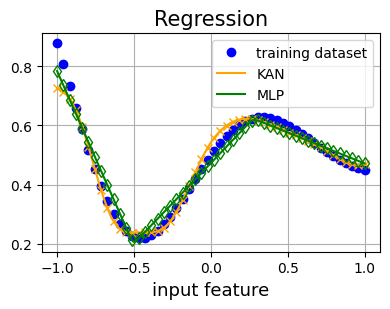

In [1]:
import numpy as np
from feed_forward_network.feedforward import FeedForward
from neuron.neuron_nn import NeuronNN
from neuron.neuron_kan import NeuronKAN
import matplotlib.pyplot as plt
from utils.activations import tanh_act, relu, sigmoid_act
from utils.edge_fun import get_bsplines

folder_fig = './'

color_plots = {'dataset': 'b',
               'kan': 'orange',
               'mlp': 'green'}


x_train = np.linspace(-1, 1, 50).reshape(-1, 1)
y_train = .5 * np.sin(4 * x_train) * np.exp(-(x_train+1)) + .5  # damped sinusoid

n_iter_train_1d = 500
loss_tol_1d = .05
seed = 476


kan_1d = FeedForward([1, 2, 2, 1],  # layer size
                  eps=.01,  # gradient descent parameter
                  n_weights_per_edge=7,  # n. edge functions
                  neuron_class=NeuronKAN,
                  x_bounds=[-1, 1],  # input domain bounds
                  get_edge_fun=get_bsplines,  # edge function type (B-splines ot Chebyshev)
                  seed=seed,
                  weights_range=[-1, 1])
kan_1d.train(x_train,
          y_train,
          n_iter_max=n_iter_train_1d,
          loss_tol=loss_tol_1d)


mlp_1d = FeedForward([1, 13, 1],  # layer size
                  eps=.005,  # gradient descend parameter
                  activation=relu,  # activation type (ReLU, tanh or sigmoid)
                  neuron_class=NeuronNN,
                  seed=seed,
                  weights_range=[-.5, .5])
mlp_1d.train(x_train,
             y_train,
             n_iter_max=n_iter_train_1d,
             loss_tol=loss_tol_1d)



# Regression on training data
fig, ax = plt.subplots(figsize=(4,3.2))
x_plot = np.linspace(x_train[0], x_train[-1], 1000).reshape(-1, 1)
ax.plot(x_train, y_train, 'o', color=color_plots['dataset'], label='training dataset')
ax.plot(x_plot, [kan_1d(x) for x in x_plot], color=color_plots['kan'], label='KAN')
ax.plot(x_train, [kan_1d(x) for x in x_train], 'x', color=color_plots['kan'], fillstyle='none')
ax.plot(x_plot, [mlp_1d(x) for x in x_plot], color=color_plots['mlp'], label='MLP')
ax.plot(x_train, [mlp_1d(x) for x in x_train], 'd', color=color_plots['mlp'], fillstyle='none')
ax.set_xlabel('input feature', fontsize=13)
ax.set_title('Regression', fontsize=15)
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()
#fig.savefig(folder_fig + 'regr1D.png', dpi=500)

Ahora se aplica KAN y MLP con un problema de regresión 2D para notar la diferencia de como interactúa cada uno con los datos de entrada:

In [6]:
def fun2d(X1, X2):
    return X1 * np.power(X2, .5)

X1, X2 = np.meshgrid(np.linspace(0, .8, 8), np.linspace(0, 1, 10))
Y_training = fun2d(X1, X2)

x_train2d = np.concatenate((X1.reshape(-1, 1), X2.reshape(-1, 1)), axis=1)
y_train2d = Y_training.reshape(-1, 1)

In [7]:
n_iter_train_2d = 500
loss_tol_2d = .1
seed = 476

In [8]:
kan_2d = FeedForward([2, 2, 1],  # layer size
                  eps=.02,  # gradient descent parameter
                  n_weights_per_edge=10,  # n. edge functions
                  neuron_class=NeuronKAN, 
                  x_bounds=[-1, 1],  # input domain bounds
                  get_edge_fun=get_bsplines,  # edge function type (B-splines ot Chebyshev)
                  seed=seed,
                  weights_range=[-1, 1])
kan_2d.train(x_train2d, 
          y_train2d, 
          n_iter_max=n_iter_train_2d, 
          loss_tol=loss_tol_2d)

 68%|██████▊   | 340/500 [00:14<00:06, 23.36it/s, loss: 0.100. Convergence has been attained!]


In [9]:
mlp_2d = FeedForward([2, 6, 1],  # layer size
                     eps=.0025,  # gradient descend parameter
                     activation=relu,  # activation type (ReLU, tanh or sigmoid)
                     neuron_class=NeuronNN, 
                     seed=seed, 
                     weights_range=[-.1, .1])
mlp_2d.train(x_train2d, 
             y_train2d, 
             n_iter_max=n_iter_train_2d, 
             loss_tol=loss_tol_2d)

100%|██████████| 500/500 [00:07<00:00, 70.54it/s, loss: 0.349]


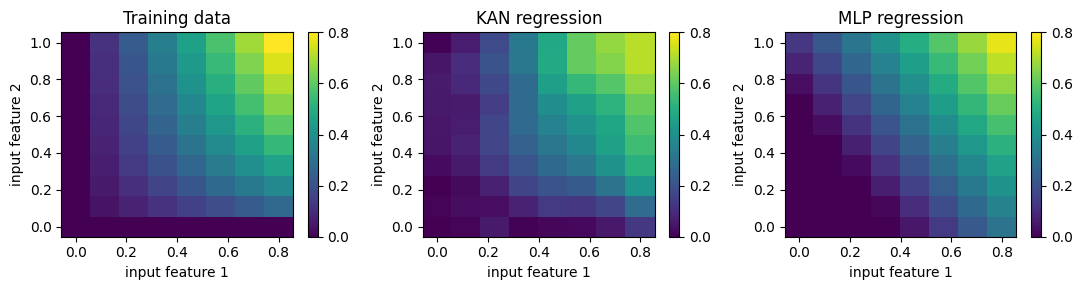

In [10]:
Y_kan = np.array([kan_2d(xx) for xx in x_train2d])
Y_mlp = np.array([mlp_2d(xx) for xx in x_train2d])

f, a = plt.subplots(1, 3, figsize=(11,3))

vmin, vmax = min(Y_training.flatten()), max(Y_training.flatten())

im0 = a[0].pcolor(X1, X2, Y_training, vmin=vmin, vmax=vmax)
f.colorbar(im0, ax=a[0])
a[0].set_title('Training data')
a[0].set_xlabel('input feature 1')
a[0].set_ylabel('input feature 2')

im1 = a[1].pcolor(X1, X2, Y_kan.reshape(X1.shape), vmin=vmin, vmax=vmax)
f.colorbar(im1, ax=a[1])
a[1].set_title('KAN regression')
a[1].set_xlabel('input feature 1')
a[1].set_ylabel('input feature 2')

im2 = a[2].pcolor(X1, X2, Y_mlp.reshape(X1.shape), vmin=vmin, vmax=vmax)
f.colorbar(im2, ax=a[2])
a[2].set_title('MLP regression')
a[2].set_xlabel('input feature 1')
a[2].set_ylabel('input feature 2')

f.tight_layout()
plt.show()
# f.savefig(folder_fig + 'regr2D.png', dpi=500)

Por ultimo, se ocupa KAN y MLP para un problema de clasificación en el conjunto de datos en forma de media luna usando el dataset "make_moons" de la librería scikit-learnmarks

In [11]:
from sklearn import datasets

n_samples = 50
noise = 0.1
x_train_cl, y_train_cl = datasets.make_moons(n_samples=n_samples, noise=noise)
# normalize between -1 and 1
x_train_cl[:, 0] = (x_train_cl[:, 0] - min(x_train_cl[:, 0])) / max(x_train_cl[:, 0] - min(x_train_cl[:, 0])) * 2 - 1
x_train_cl[:, 1] = (x_train_cl[:, 1] - min(x_train_cl[:, 1])) / max(x_train_cl[:, 1] - min(x_train_cl[:, 1])) * 2 - 1


In [12]:
n_iter_train_cl = int(1e3)
loss_tol_cl = 1.5
seed = 476

In [13]:
from loss.cross_entropy_loss import CrossEntropyLoss

kan_cl = FeedForward([2, 2],  # layer size
                     eps=.02,  # gradient descent parameter
                     n_weights_per_edge=8,  # n. edge functions
                     neuron_class=NeuronKAN, 
                     loss=CrossEntropyLoss,
                     x_bounds=[-1, 1],  # input domain bounds
                     get_edge_fun=get_bsplines,  # edge function type (B-splines ot Chebyshev)
                     seed=seed,
                     weights_range=[-1, 1])
kan_cl.train(x_train_cl, 
             y_train_cl.reshape(-1, 1), 
             n_iter_max=n_iter_train_cl, 
             loss_tol=loss_tol_cl)

100%|██████████| 1000/1000 [00:15<00:00, 63.54it/s, loss: 7.056]


In [14]:
mlp_cl = FeedForward([2, 10, 10, 2],  # layer size
                     eps=.01,  # gradient descend parameter
                     activation=tanh_act,  # activation type (relu, tanh_act or sigmoid_act)
                     neuron_class=NeuronNN, 
                     loss=CrossEntropyLoss,
                     seed=seed, 
                     weights_range=[-1, 1])
mlp_cl.train(x_train_cl, 
             y_train_cl.reshape(-1, 1), 
             n_iter_max=n_iter_train_cl, 
             loss_tol=loss_tol_cl)

100%|██████████| 1000/1000 [00:21<00:00, 46.69it/s, loss: 6.421]


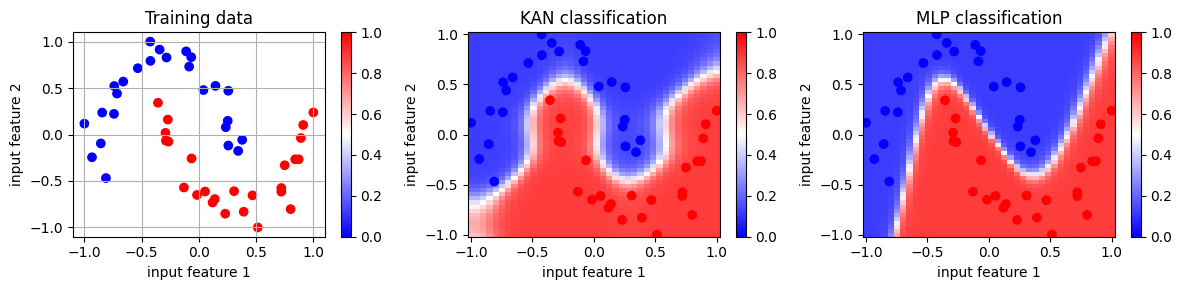

In [15]:
def softmax(vec):
    return np.exp(vec) / sum(np.exp(vec))

X1_cl, X2_cl = np.meshgrid(np.linspace(-1, 1, 40), np.linspace(-1, 1, 50))
x_cl = np.concatenate((X1_cl.reshape(-1, 1), X2_cl.reshape(-1, 1)), axis=1)

Y_kan_cl = np.array([softmax(kan_cl(x))[1] for x in x_cl]).reshape(X1_cl.shape)
Y_mlp_cl = np.array([softmax(mlp_cl(x))[1] for x in x_cl]).reshape(X1_cl.shape)

fig_cl, ax_cl = plt.subplots(1, 3, figsize=(12,3))
# vmin, vmax = min(Y_training.flatten()), max(Y_training.flatten())

ax_cl[0].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[0].grid()
ax_cl[0].set_title('Training data')
ax_cl[0].set_xlabel('input feature 1')
ax_cl[0].set_ylabel('input feature 2')

im0 = ax_cl[1].pcolor(X1_cl, X2_cl, Y_kan_cl, vmin=0, vmax=1, cmap=plt.cm.bwr)
ax_cl[1].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[1].set_title('KAN classification')
ax_cl[1].set_xlabel('input feature 1')
ax_cl[1].set_ylabel('input feature 2')

im1 = ax_cl[2].pcolor(X1_cl, X2_cl, Y_mlp_cl, vmin=0, vmax=1, cmap=plt.cm.bwr)
ax_cl[2].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[2].set_title('MLP classification')
ax_cl[2].set_xlabel('input feature 1')
ax_cl[2].set_ylabel('input feature 2')

fig_cl.colorbar(im1, ax=ax_cl[0])
fig_cl.colorbar(im1, ax=ax_cl[1])
fig_cl.colorbar(im1, ax=ax_cl[2])
fig_cl.tight_layout()
plt.show()
# fig_cl.savefig(folder_fig + 'classification.png', dpi=500)

# Pregunta 2


## Obtenga resultados de ejecución de las ANN como en el tutorial. En el punto 5 del tutorial, modifique los datos de entrada usando otros datasets y vuelva a hacer comparaciones entre los resultados obtenidos de las distintas redes usadas en el tutorial

In [ ]:
import numpy as np
from feed_forward_network.feedforward import FeedForward
from neuron.neuron_nn import NeuronNN
from neuron.neuron_kan import NeuronKAN
import matplotlib.pyplot as plt
from utils.activations import tanh_act, relu, sigmoid_act
from utils.edge_fun import get_bsplines

import pandas as pd
from sklearn.datasets import load_diabetes  # Ejemplo: Dataset de Boston Housing
from sklearn.preprocessing import StandardScaler

# Cargar el dataset de Boston Housing
data = load_diabetes()
x_train = data.data[:, [0]].reshape(-1, 1)  # Selecciona una característica
y_train = data.target.reshape(-1, 1)


color_plots = {'dataset': 'b',
               'kan': 'orange',
               'mlp': 'green'}

n_iter_train_1d = 5
loss_tol_1d = .05
seed = 476
 
#x_train = np.linspace(-1, 1, 50).reshape(-1, 1)
#y_train = .5 * np.sin(4 * x_train) * np.exp(-(x_train+1)) + .5  # damped sinusoid

# Estandarizar las características
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)


# KAN training
kan_1d = FeedForward([1, 2, 2, 1],  # layer size
                  eps=.01,  # gradient descent parameter
                  n_weights_per_edge=7,  # n. edge functions
                  neuron_class=NeuronKAN, 
                  x_bounds=[-1, 1],  # input domain bounds
                  get_edge_fun=get_bsplines,  # edge function type (B-splines ot Chebyshev)
                  seed=seed,
                  weights_range=[-1, 1])
kan_1d.train(x_train, 
          y_train, 
          n_iter_max=n_iter_train_1d, 
          loss_tol=loss_tol_1d)
 

# MLP training
mlp_1d = FeedForward([1, 13, 1],  # layer size
                  eps=.005,  # gradient descend parameter
                  activation=relu,  # activation type (ReLU, tanh or sigmoid)
                  neuron_class=NeuronNN, 
                  seed=seed,
                  weights_range=[-.5, .5])
mlp_1d.train(x_train, 
             y_train, 
             n_iter_max=n_iter_train_1d, 
             loss_tol=loss_tol_1d)


# Regression on training data
fig, ax = plt.subplots(figsize=(4,3.2))
x_plot = np.linspace(x_train[0], x_train[-1], 1000).reshape(-1, 1)
ax.plot(x_train, y_train, 'o', color=color_plots['dataset'], label='training dataset')
ax.plot(x_plot, [kan_1d(x) for x in x_plot], color=color_plots['kan'], label='KAN')
ax.plot(x_train, [kan_1d(x) for x in x_train], 'x', color=color_plots['kan'], fillstyle='none')
ax.plot(x_plot, [mlp_1d(x) for x in x_plot], color=color_plots['mlp'], label='MLP')
ax.plot(x_train, [mlp_1d(x) for x in x_train], 'd', color=color_plots['mlp'], fillstyle='none')
ax.set_xlabel('input feature', fontsize=13)
ax.set_title('Regression', fontsize=15)
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

# Pregunta 3





## Explique en sus propias palabras cómo está construida la arquitectura KAN y por qué funciona. Además, haga un análisis sobre los resultados obtenidos y cómo y por qué podrían variar.